In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import seaborn as sns

from module.one_dim.layers import *
from module.one_dim.generators import *

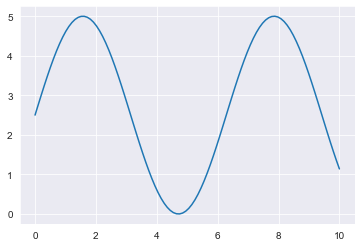

In [6]:
x = np.linspace(0, 10, 100)
y = 5 * (np.sin(x) + 1)/2
plt.plot(x, y)

In [216]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [210]:
shape = (100, 100)
inputs = tf.keras.Input(196)
x = IntensityToElectricField()(inputs)
#x = Modulation()(x)
#x = AngularSpectrum(z=0.1e-3, method="expand")(x)
x = ElectricFieldToIntensity()(x)
# x = Detector(10, padding=0.2, interval=1.0)(x)
x = Filter(10, padding=0.2, interval=1.0)(x)

model = tf.keras.Model(inputs, x)

2022-07-11 17:17:51.145110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


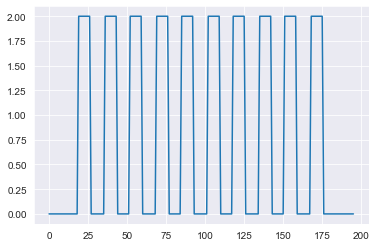

In [212]:
one = np.ones([5, 196])
one[0,:] = 2

pred = model.predict(one)
plt.plot(pred[0,:])

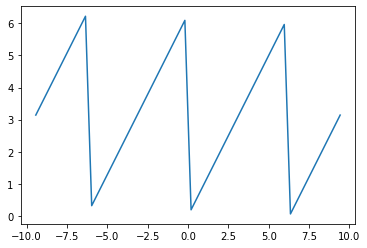

In [6]:
phase = np.linspace(-3*np.pi, 3*np.pi)
plt.plot(phase, phase % (2*np.pi))

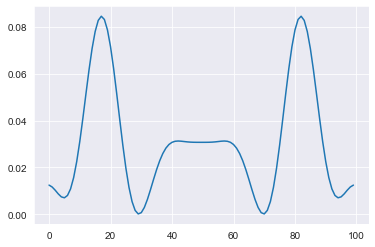

In [5]:
input_pattern = np.zeros(100)
input_pattern[45:55] = 1
wavelength = 633e-9
z = 1.0e-2
d = 1.0e-6

u = np.fft.fftfreq(100, d=d)
w = np.where(u ** 2 <= 1 / wavelength ** 2, tf.sqrt(1 / wavelength**2 - u**2), 0).astype('float64')
h = np.exp(1.0j * 2 * np.pi * w * z)
du = 1/(2*200 * d)
u_limit = 1/(np.sqrt((2 * du * z)**2 + 1)) / wavelength
u_filter = np.where(np.abs(u)/(2*u_limit) <= 1/2, 1, 0)
h = h * u_filter
fft_input = np.fft.fft(input_pattern)
out = np.fft.ifft(fft_input * h)
I = np.abs(out)**2/2

plt.plot(I)

In [135]:
(2*(200*d)**2/(z*wavelength))

12.63823064770932

In [136]:
np.sum(u_filter)

13

In [3]:
model.save("trained_model/test")
model = tf.keras.models.load_model("trained_model/test")

INFO:tensorflow:Assets written to: trained_model/test/assets


In [2]:
def propagation(x, wavelength, d, z, n=1):
    d = d
    wavelength_effect = wavelength / n
    pad_width = math.ceil(x.shape[-1] / 2)
    padded_width = int(x.shape[-1] + pad_width * 2)

    u = np.fft.fftfreq(padded_width, d=d)

    du = 1 / (padded_width * d)
    u_limit = 1 / (np.sqrt((2 * du * z) ** 2 + 1)) / wavelength_effect

    u_filter = np.where(np.abs(u) <= u_limit, 1.0, 0.0)

    w = np.where(u ** 2 <= 1 / wavelength_effect ** 2, tf.sqrt(1 / wavelength_effect ** 2 - u ** 2), 0).astype('float64')
    h = np.exp(1.0j * 2 * np.pi * w * z)
    h = h * u_filter

    padding = [pad_width, pad_width]
    images_pad = np.pad(x, pad_width=padding)
    images_pad_fft = np.fft.fft(images_pad)
    u_images_pad = np.fft.ifft(images_pad_fft * h)
    u_images = u_images_pad[pad_width:pad_width + x.shape[-1]]
    #I = np.abs(u_images) ** 2/2
    return u_images

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_4630/2920176006.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axes[0].pcolormesh(YY, XX, outs.real, cmap='BuPu_r')


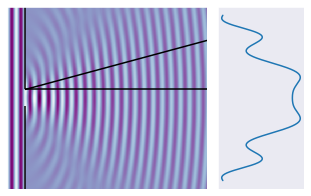

In [13]:
from matplotlib.colors import LinearSegmentedColormap
cmap12 = LinearSegmentedColormap.from_list('custom', ["#9c9eda", "#924c4a", "#513c28"])

wavelength = 533e-9
resol = 500
x = np.linspace(-wavelength*10, wavelength*10, resol)
z1 = np.linspace(0, wavelength*20, resol)
z2 = np.linspace(-wavelength*2, 0, 100)
XX1, YY1 = np.meshgrid(x, z1)
XX2, YY2 = np.meshgrid(x, z2)
XX = np.vstack([XX2, XX1])
YY = np.vstack([YY2, YY1])


outs2 = np.exp(1.0j * 2*np.pi/wavelength * YY2)
d = 1.0e-6/100
input_pattern = np.zeros(resol)
input_pattern[200:300] = 1
outs1 = []

theta = np.arcsin(wavelength/(2*d*100))

for _z in z1:
    out = propagation(outs2[-1,:] * input_pattern, wavelength, d, _z)
    outs1.append(out)

outs1 = np.array(outs1)
outs = np.vstack([outs2, outs1])
fig, axes = plt.subplots(1,2)
axes[0].pcolormesh(YY, XX, outs.real, cmap='BuPu_r')
axes[0].plot(np.array([0, z1[-1]]), np.array([0, z1[-1]])*theta + 50*d, color="black")
axes[0].hlines(50*d, 0, z1[-1], color="black")
axes[0].vlines(0, 50*d, x[-1], color="black")
axes[0].vlines(0, -50*d, -x[-1], color="black")
axes[0].grid(False)
axes[0].set_xticks([],[])
axes[0].set_yticks([],[])
axes[0].set_aspect("equal")
axes[1].plot(np.abs(outs[-1,:]**2), x)
axes[1].set_xticks([],[])
axes[1].set_yticks([],[])
fig.tight_layout()
##これを付け足すと揃う
fig.canvas.draw()
axpos1 = axes[0].get_position() # 上の図の描画領域
axpos2 = axes[1].get_position() # 下の図の描画領域
#幅をax1と同じにする
axes[1].set_position([axpos2.x0, axpos1.y0, 0.2, axpos1.height])
plt.savefig("out/angle.png", dpi=300, transparent=True)

In [95]:
outs2.shape

(100, 500)

In [3]:
data = np.loadtxt("out/phase.csv", skiprows=1, delimiter=",")
data

array([[0.        , 6.2006516 , 5.9023347 , 0.82382214, 1.3053756 ,
        5.88291   ],
       [0.        , 0.0675895 , 5.4771686 , 5.539121  , 0.768272  ,
        4.382264  ],
       [0.        , 0.87144655, 5.86895   , 0.06041505, 0.87099946,
        3.5460293 ],
       ...,
       [0.        , 1.1500993 , 6.0681095 , 0.24118151, 5.6098146 ,
        1.4798129 ],
       [0.        , 0.60177016, 5.8469014 , 6.0326366 , 6.113349  ,
        0.8364769 ],
       [0.        , 6.1791544 , 1.2016878 , 1.1554384 , 0.4219876 ,
        2.0600402 ]])

In [39]:
images = tf.image.resize(tf.expand_dims(x_train, -1), (14, 14))
images

NameError: name 'x_train' is not defined

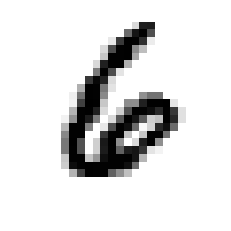

In [273]:
plt.imshow(x_train[13,:,:], cmap="binary")
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])
plt.savefig("out/6.png")

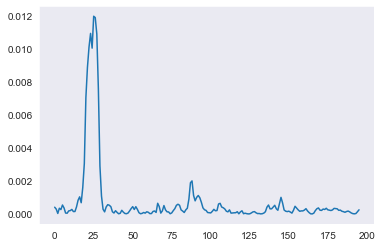

In [8]:
intens = data[:, 0].flatten()
# intens = images[13,:,:].numpy().reshape(-1)
z = 40.e-6
x = intens
x = x * np.exp(1.0j * data[:,1].flatten())
x = propagation(x, 1.55e-6, 0.5e-6, z)
x = x * np.exp(1.0j * data[:,2].flatten())
x = propagation(x, 1.55e-6, 0.5e-6, z)
x = x * np.exp(1.0j * data[:,3].flatten())
x = propagation(x, 1.55e-6, 0.5e-6, z)
x = x * np.exp(1.0j * data[:,4].flatten())
x = propagation(x, 1.55e-6, 0.5e-6, z)
x = x * np.exp(1.0j * data[:,5].flatten())
x = propagation(x, 1.55e-6, 0.5e-6, z)

plt.plot(np.abs(x)**2/2)
plt.grid(False)

In [35]:
array1 = []
array2 = []
array3 = []
array4 = []
array5 = []

In [42]:
zz = np.linspace(0, 40.e-6, 100)
wavelength = 1.55e-6
d = 0.5e-6
z = 40.e-6
x = intens
x = x * np.exp(1.0j * data[:,1].flatten())
for _z in zz:
    array1.append(propagation(x, wavelength, d, _z))

Metal device set to: Apple M1


2022-07-15 11:35:54.307883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-15 11:35:54.308058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_310/931297809.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(ZZ.T, YY.T, image, cmap="bwr")


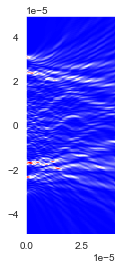

In [70]:
image = np.array(array1).T
y = np.arange(image.shape[0]) * 0.5e-6
y = y - np.mean(y)
YY, ZZ = np.meshgrid(y, zz)
plt.pcolormesh(ZZ.T, YY.T, image, cmap="bwr")
plt.grid(False)
plt.gca().set_aspect("equal")
plt.savefig("out/aaaa.png", dpi=300)

In [267]:
array1 = np.array(array1).T
array2 = np.array(array2).T
array3 = np.array(array3).T
array4 = np.array(array4).T
array5 = np.array(array5).T
array = [array1, array2, array3, array4, array5]

NameError: name 'array' is not defined

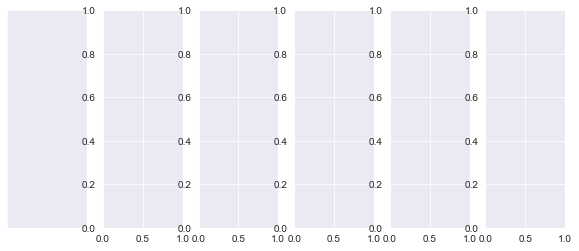

In [33]:
fig, axes = plt.subplots(1, 6, figsize=(10,4))
for i, ax in enumerate(axes):
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if i == 5:
        out = array[-1][:,-1]
        ax.plot(out/np.max(out), -np.arange(len(out)), color = "purple")
        ax.set_ylim(np.min(-np.arange(len(out))), 0)
        ax.set_facecolor('white')
        ax.fill_betweenx(-np.arange(len(out)), 0, pred[0,:]/2, alpha=0.3)
    else:
        ax.imshow(array[i], cmap="CMRmap")

fig.tight_layout()
axpos1 = axes[4].get_position() # 上の図の描画領域
axpos2 = axes[5].get_position() # 下の図の描画領域
#幅をax1と同じにする
axes[5].set_position([axpos2.x0, axpos2.y0+0.1, axpos1.width, axpos1.height])
fig.savefig("out/all.png", dpi=300)

/Users/takumi/miniforge3/envs/tensorflow25/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


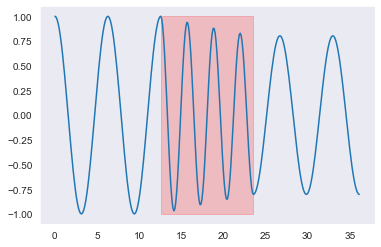

In [314]:
x1 = np.linspace(0, np.pi*4, 100)
x2 = np.linspace(x1[-1], x1[-1] + np.pi*3.5, 100)
x3 = np.linspace(x2[-1], x2[-1]+ np.pi*4, 100)

N = 2 + 0.02j

y1 = np.exp(1.0j * x1)
y2 = np.exp(1.0j * N * (x2 - x2[0]))
y3 = np.exp(1.0j * (N * (x2[-1]-x2[0]) + (x3 - x3[0])))
x = np.hstack([x1, x2, x3])
y = np.hstack([y1, y2, y3])

plt.figure(facecolor="white")
plt.plot(x, y)
plt.fill_between(x2, -1, 1, alpha=0.2, color="red")
plt.grid(False)

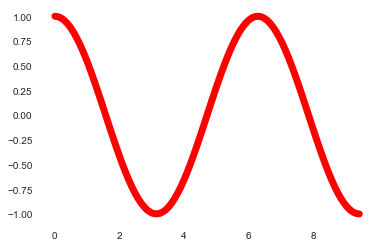

In [86]:
x = np.linspace(0, 3*np.pi, 100)
y = np.cos(x)

fig, ax = plt.subplots()
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.plot(x, y, color="r", lw=7)
ax.grid(False)
fig.savefig("out/wave.png", transparent=True)

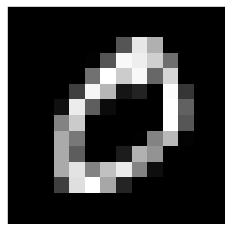

In [96]:
plt.imshow(np.reshape(data[:,0], (14,14)), cmap="gray")
plt.grid(False)
plt.xticks([],[])
plt.yticks([], [])
plt.savefig("out/0.png", dpi=500)